In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

overlap_thresholds = [0.1, 0.2, 0.5]

# load sleep stages

In [2]:
dreams_sleep_stages_glob = os.path.expanduser("~/data/dreams/DatabaseSpindles/Hypnogram_*.txt")
gt_stages_all = {}

for f_path in sorted(glob(dreams_sleep_stages_glob), key=lambda x: int(x[-5])):
    f_id = f"excerpt{f_path[-5]}"
    with open(f_path) as f:
        gt_stages = [int(l) for l in f.readlines()[1:]]
        # map REM from 5 to 4
        gt_stages = [4 if s == 5 else s for s in gt_stages]

    gt_stages_all[f_id] = np.array(gt_stages)

# shared functions

In [3]:
def overlap(spindles, sleepstages):
    sleepstages = sleepstages == 2
    spindle_centers = (spindles[:, :2].sum(axis=1) // 2).astype(int)
    # sleep stages were annotated in 5s epochs
    if len(sleepstages) < max(spindle_centers) // 5:
        print(f'Warning: sleepstages shorter than spindles, '
              f'ignoring {sum(spindle_centers // 5 >= len(sleepstages))} spindles')
    idx = [sleepstages[center // 5]
           if center // 5 < len(sleepstages) else False
           for center in spindle_centers]
    return spindles[idx]


def calc_tp_fp_fn(gt_spindles, pred_spindles, spindle_thresholds):
    tp, fp = [0] * len(spindle_thresholds), [0] * len(spindle_thresholds)

    used_spindles = [np.zeros(len(gt_spindles)) for _ in range(len(spindle_thresholds))]
    gt_start = 0
    for pred_s in pred_spindles:
        intersects = [0] * len(gt_spindles)
        unions = [0] * len(gt_spindles)
        for gt_i in range(gt_start, len(gt_spindles)):
            gt_s = gt_spindles[gt_i]
            if pred_s[1] < gt_s[0]:
                break
            if pred_s[0] > gt_s[1]:
                gt_start = gt_i + 1
                continue
            intersects[gt_i] = min(gt_s[1], pred_s[1]) - max(gt_s[0], pred_s[0])
            unions[gt_i] = max(gt_s[1], pred_s[1]) - min(gt_s[0], pred_s[0])
        ious = [intersects[i] / unions[i] if unions[i] > 0 else 0
                for i in range(len(intersects))]
        for i, spindle_threshold in enumerate(spindle_thresholds):
            if len(ious) > 0 and max(ious) > spindle_threshold:
                tp[i] += 1
                used_spindles[i][np.argmax(ious)] = 1
            else:
                fp[i] += 1

    fn = [len(gt_spindles) - np.sum(used_spindles[i]) for i in range(len(spindle_thresholds))]

    return tp, fp, fn


def merge_and_filter_spindles(spindles, merge_dur=0.3, merge_dist=0.1, min_dur=0.3, max_dur=2.5):
    sort_idx = np.argsort(spindles[:, 0])
    spindles = spindles[sort_idx]
    durations = np.diff(spindles, axis=1).squeeze()
    distances = spindles[1:, 0] - spindles[:-1, 1]
    to_merge = (durations[:-1] < merge_dur) & (durations[1:] < merge_dur) & (distances < merge_dist)
    spindles[np.r_[to_merge, False], 1] = spindles[np.r_[False, to_merge], 1]
    spindles = spindles[~np.r_[False, to_merge]]

    durations = np.diff(spindles, axis=1).squeeze()
    to_filter = (durations < min_dur) | (durations > max_dur)
    spindles = spindles[~to_filter]

    print(f'Merged {np.sum(to_merge)} spindles, filtered {np.sum(to_filter)} spindles')

    return spindles

# load spindles

In [4]:
pred_path = '../../output/annotations/dreams/*_aggregated.npz'
pred_files = glob(pred_path)
pred_data = {}
for f in pred_files:
    pred_data_i = np.load(f)
    assert len(pred_data_i) == 1
    pred_data[f.split('/')[-1].split('_')[0]] = pred_data_i[list(pred_data_i.keys())[0]]

gt_glob_1 = os.path.expanduser('~/data/dreams/DatabaseSpindles/Visual_scoring1_*txt')
gt_glob_2 = os.path.expanduser('~/data/dreams/DatabaseSpindles/Visual_scoring2_*txt')


def extract_spindles(file):
    with open(file, "r") as f:
        lines = f.readlines()

    spindle_starts = np.array([float(l.split("\t")[0].strip()) for l in lines[1:]])
    spindle_durations = np.array([float(l.split("\t")[1].strip()) for l in lines[1:]])

    return spindle_starts, spindle_durations


gt_data_1 = {}
gt_data_2 = {}
for file in glob(gt_glob_1):
    excerpt_id = os.path.split(file)[-1].split(".")[0].split("_")[-1]
    spindle_starts, spindle_durations = extract_spindles(file)
    gt_data_1[excerpt_id] = np.array([spindle_starts, spindle_starts + spindle_durations]).T
for file in glob(gt_glob_2):
    excerpt_id = os.path.split(file)[-1].split(".")[0].split("_")[-1]
    spindle_starts, spindle_durations = extract_spindles(file)
    gt_data_2[excerpt_id] = np.array([spindle_starts, spindle_starts + spindle_durations]).T

unq_ids = set(gt_data_1.keys()) | set(gt_data_2.keys())

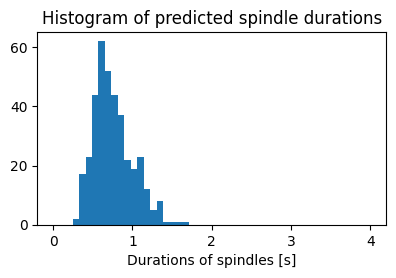

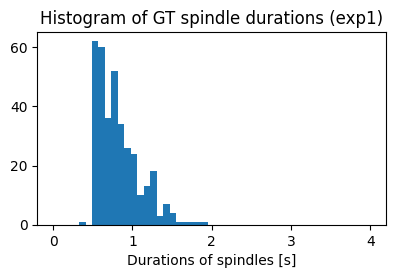

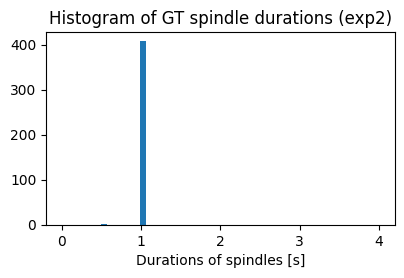

In [5]:
pred_spindles_all = {}
for f_id in unq_ids:
    pred_spindles_all[f_id] = pred_data[f"{f_id}"]

plt.figure(figsize=(4.5, 2.5))
plt.title('Histogram of predicted spindle durations')
plt.hist(np.concatenate([np.diff(s[:, :2]) for s in pred_data.values()]), bins=np.linspace(0, 4, 50))
plt.xlabel('Durations of spindles [s]')
plt.show()

plt.figure(figsize=(4.5, 2.5))
plt.title('Histogram of GT spindle durations (exp1)')
plt.hist(np.concatenate([np.diff(s[:, :2]) for s in gt_data_1.values()]), bins=np.linspace(0, 4, 50))
plt.xlabel('Durations of spindles [s]')
plt.show()

plt.figure(figsize=(4.5, 2.5))
plt.title('Histogram of GT spindle durations (exp2)')
plt.hist(np.concatenate([np.diff(s[:, :2]) for s in gt_data_2.values()]), bins=np.linspace(0, 4, 50))
plt.xlabel('Durations of spindles [s]')
plt.show()

# compare predicted spindles to exp1

In [6]:
f1_scores = {ovt: {} for ovt in overlap_thresholds}
precision_scores = {ovt: {} for ovt in overlap_thresholds}
recall_scores = {ovt: {} for ovt in overlap_thresholds}

total_tp = {ovt: 0 for ovt in overlap_thresholds}
total_fp = {ovt: 0 for ovt in overlap_thresholds}
total_fn = {ovt: 0 for ovt in overlap_thresholds}
for f_id in sorted(unq_ids, key=lambda x: int(x[-1])):
    gt_sleep_stages = gt_stages_all[f_id]
    gt_spindles = gt_data_1[f_id][:, :2]
    pred_spindles = pred_spindles_all[f_id][:, :2]

    spindles_filtered = overlap(pred_spindles, gt_sleep_stages)
    spindles_filtered = merge_and_filter_spindles(spindles_filtered)
    gt_data_filtered = overlap(gt_spindles, gt_sleep_stages)

    tp, fp, fn = calc_tp_fp_fn(gt_data_filtered, spindles_filtered, overlap_thresholds)

    for i, ov_thresh in enumerate(overlap_thresholds):
        total_tp[ov_thresh] += tp[i]
        total_fp[ov_thresh] += fp[i]
        total_fn[ov_thresh] += fn[i]

        prec = tp[i] / (tp[i] + fp[i]) if tp[i] + fp[i] > 0 else 1
        rec = tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] > 0 else 1
        f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        print(
            f'File {f_id}, overlap threshold: {ov_thresh}, #spindles pred: {len(spindles_filtered)}, '
            f'#spindles gt: {len(gt_data_filtered)}, spindle frac: {len(spindles_filtered) / len(gt_data_filtered):.2f}, '
            f'prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')
        f1_scores[ov_thresh][f_id] = f1
        precision_scores[ov_thresh][f_id] = prec
        recall_scores[ov_thresh][f_id] = rec

Merged 0 spindles, filtered 0 spindles
File excerpt1, overlap threshold: 0.1, #spindles pred: 60, #spindles gt: 52, spindle frac: 1.15, prec: 0.567, rec: 0.654, f1: 0.607
File excerpt1, overlap threshold: 0.2, #spindles pred: 60, #spindles gt: 52, spindle frac: 1.15, prec: 0.567, rec: 0.654, f1: 0.607
File excerpt1, overlap threshold: 0.5, #spindles pred: 60, #spindles gt: 52, spindle frac: 1.15, prec: 0.567, rec: 0.654, f1: 0.607
Merged 0 spindles, filtered 0 spindles
File excerpt2, overlap threshold: 0.1, #spindles pred: 48, #spindles gt: 54, spindle frac: 0.89, prec: 0.688, rec: 0.611, f1: 0.647
File excerpt2, overlap threshold: 0.2, #spindles pred: 48, #spindles gt: 54, spindle frac: 0.89, prec: 0.688, rec: 0.611, f1: 0.647
File excerpt2, overlap threshold: 0.5, #spindles pred: 48, #spindles gt: 54, spindle frac: 0.89, prec: 0.646, rec: 0.574, f1: 0.608
Merged 0 spindles, filtered 0 spindles
File excerpt3, overlap threshold: 0.1, #spindles pred: 30, #spindles gt: 5, spindle frac: 6

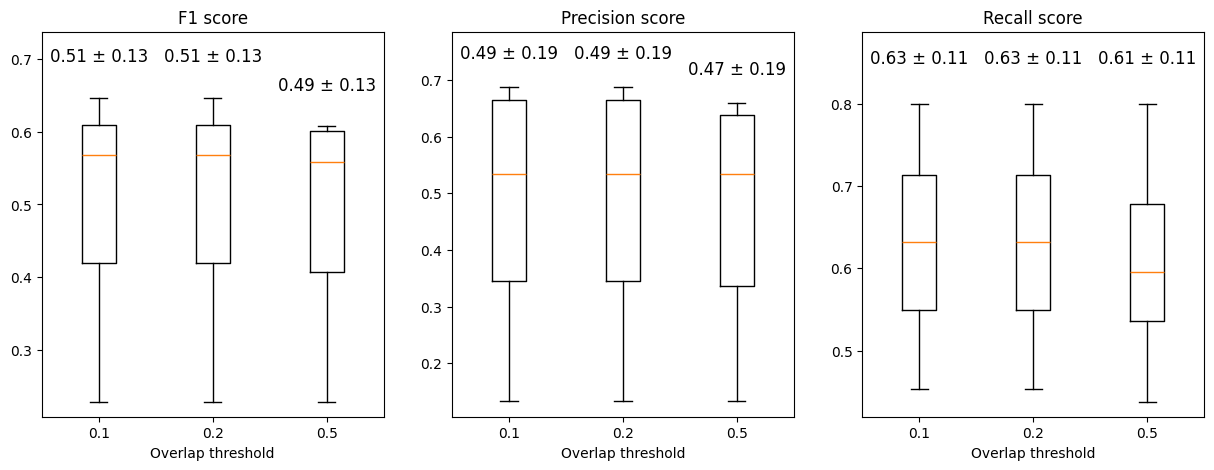

Expert centered scores:
Overlap threshold: 0.1, prec: 0.479, rec: 0.599, f1: 0.532
Overlap threshold: 0.2, prec: 0.479, rec: 0.599, f1: 0.532
Overlap threshold: 0.5, prec: 0.457, rec: 0.572, f1: 0.508


In [7]:
# plot f1 scores as boxplot
def plot_scores(f1_scores, precision_scores, recall_scores):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    f1_scores_to_plot = [np.array(list(f1_scores[k].values())) for k in f1_scores.keys()]
    bps = plt.boxplot(f1_scores_to_plot)
    for i in range(len(f1_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{f1_scores_to_plot[i].mean():.2f} ± {f1_scores_to_plot[i].std():.2f}", size=12, ha="center")
    plt.xticks(range(1, len(f1_scores.keys()) + 1), f1_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.title('F1 score')

    plt.subplot(1, 3, 2)
    precision_scores_to_plot = [np.array(list(precision_scores[k].values())) for k in
                                precision_scores.keys()]
    bps = plt.boxplot(precision_scores_to_plot)
    for i in range(len(precision_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{precision_scores_to_plot[i].mean():.2f} ± {precision_scores_to_plot[i].std():.2f}", size=12,
                 ha="center")
    plt.xticks(range(1, len(precision_scores.keys()) + 1), precision_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.title('Precision score')

    plt.subplot(1, 3, 3)
    recall_scores_to_plot = [np.array(list(recall_scores[k].values())) for k in recall_scores.keys()]
    bps = plt.boxplot(recall_scores_to_plot)
    for i in range(len(recall_scores.keys())):
        plt.text(i + 1, bps["whiskers"][2 * i + 1].get_ydata()[1] + 0.05,
                 f"{recall_scores_to_plot[i].mean():.2f} ± {recall_scores_to_plot[i].std():.2f}", size=12, ha="center")
    plt.xticks(range(1, len(recall_scores.keys()) + 1), recall_scores.keys())
    plt.xlabel('Overlap threshold')
    plt.title('Recall score')
    plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.07)
    plt.show()


plot_scores(f1_scores, precision_scores, recall_scores)

print('Expert centered scores:')
for i, ov_thresh in enumerate(overlap_thresholds):
    prec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fp[ov_thresh]) if total_tp[ov_thresh] + total_fp[
        ov_thresh] > 0 else 1
    rec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fn[ov_thresh]) if total_tp[ov_thresh] + total_fn[
        ov_thresh] > 0 else 1
    f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    print(f'Overlap threshold: {ov_thresh}, prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')

# compare predicted spindles to exp2

In [8]:
f1_scores = {ovt: {} for ovt in overlap_thresholds}
precision_scores = {ovt: {} for ovt in overlap_thresholds}
recall_scores = {ovt: {} for ovt in overlap_thresholds}

total_tp = {ovt: 0 for ovt in overlap_thresholds}
total_fp = {ovt: 0 for ovt in overlap_thresholds}
total_fn = {ovt: 0 for ovt in overlap_thresholds}
for f_id in sorted(unq_ids, key=lambda x: int(x[-1])):
    if f_id in ['excerpt7', 'excerpt8']:
        continue
    gt_sleep_stages = gt_stages_all[f_id]
    gt_spindles = gt_data_2[f_id][:, :2]
    pred_spindles = pred_spindles_all[f_id][:, :2]

    spindles_filtered = overlap(pred_spindles, gt_sleep_stages)
    spindles_filtered = merge_and_filter_spindles(spindles_filtered)
    gt_data_filtered = overlap(gt_spindles, gt_sleep_stages)
    # gt_data_filtered = merge_and_filter_spindles(gt_data_filtered)

    tp, fp, fn = calc_tp_fp_fn(gt_data_filtered, spindles_filtered, overlap_thresholds)

    for i, ov_thresh in enumerate(overlap_thresholds):
        total_tp[ov_thresh] += tp[i]
        total_fp[ov_thresh] += fp[i]
        total_fn[ov_thresh] += fn[i]

        prec = tp[i] / (tp[i] + fp[i]) if tp[i] + fp[i] > 0 else 1
        rec = tp[i] / (tp[i] + fn[i]) if tp[i] + fn[i] > 0 else 1
        f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
        print(
            f'File {f_id}, overlap threshold: {ov_thresh}, #spindles pred: {len(spindles_filtered)}, '
            f'#spindles gt: {len(gt_data_filtered)}, spindle frac: {len(spindles_filtered) / len(gt_data_filtered):.2f}, '
            f'prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')
        f1_scores[ov_thresh][f_id] = f1
        precision_scores[ov_thresh][f_id] = prec
        recall_scores[ov_thresh][f_id] = rec

Merged 0 spindles, filtered 0 spindles
File excerpt1, overlap threshold: 0.1, #spindles pred: 60, #spindles gt: 81, spindle frac: 0.74, prec: 0.883, rec: 0.654, f1: 0.752
File excerpt1, overlap threshold: 0.2, #spindles pred: 60, #spindles gt: 81, spindle frac: 0.74, prec: 0.883, rec: 0.654, f1: 0.752
File excerpt1, overlap threshold: 0.5, #spindles pred: 60, #spindles gt: 81, spindle frac: 0.74, prec: 0.733, rec: 0.543, f1: 0.624
Merged 0 spindles, filtered 0 spindles
File excerpt2, overlap threshold: 0.1, #spindles pred: 48, #spindles gt: 46, spindle frac: 1.04, prec: 0.792, rec: 0.826, f1: 0.809
File excerpt2, overlap threshold: 0.2, #spindles pred: 48, #spindles gt: 46, spindle frac: 1.04, prec: 0.792, rec: 0.826, f1: 0.809
File excerpt2, overlap threshold: 0.5, #spindles pred: 48, #spindles gt: 46, spindle frac: 1.04, prec: 0.750, rec: 0.783, f1: 0.766
Merged 0 spindles, filtered 0 spindles
File excerpt3, overlap threshold: 0.1, #spindles pred: 30, #spindles gt: 38, spindle frac: 

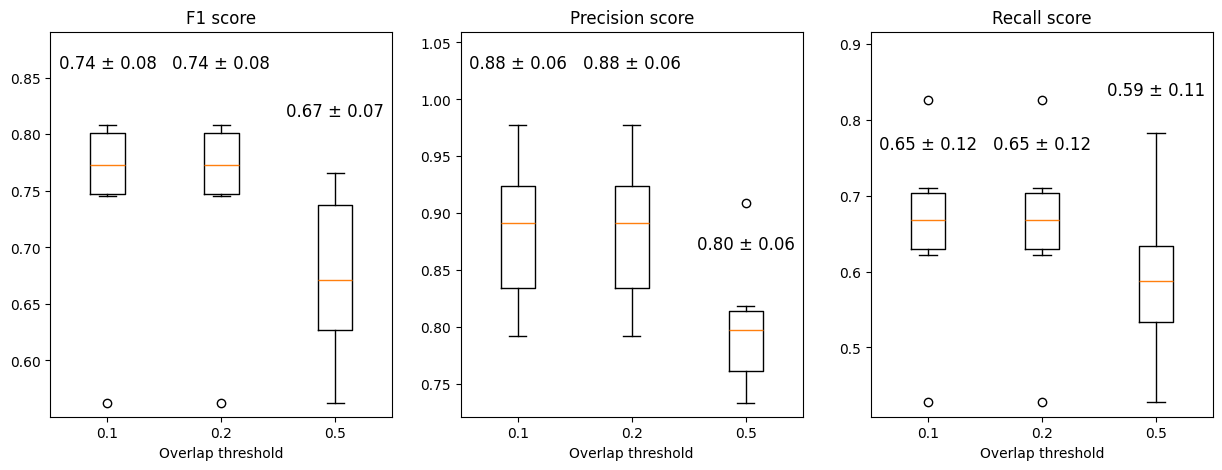

Expert centered scores:
Overlap threshold: 0.1, prec: 0.890, rec: 0.670, f1: 0.764
Overlap threshold: 0.2, prec: 0.890, rec: 0.670, f1: 0.764
Overlap threshold: 0.5, prec: 0.793, rec: 0.597, f1: 0.681


In [9]:
plot_scores(f1_scores, precision_scores, recall_scores)

print('Expert centered scores:')
for i, ov_thresh in enumerate(overlap_thresholds):
    prec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fp[ov_thresh]) if total_tp[ov_thresh] + total_fp[
        ov_thresh] > 0 else 1
    rec = total_tp[ov_thresh] / (total_tp[ov_thresh] + total_fn[ov_thresh]) if total_tp[ov_thresh] + total_fn[
        ov_thresh] > 0 else 1
    f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    print(f'Overlap threshold: {ov_thresh}, prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}')

# spindle metrics

In [10]:
ovt = 0.2
spm_per_seg_gt_1 = []
spm_per_seg_gt_2 = []
spm_per_seg_pred = []

for s_id in unq_ids:
    gt_spindles_1 = gt_data_1[s_id]
    gt_spindles_1 = overlap(gt_spindles_1, gt_stages_all[s_id])
    spm_per_seg_gt_1.append(len(gt_spindles_1) / sum(gt_stages_all[s_id] == 2) * 12)

    if s_id not in ['excerpt7', 'excerpt8']:
        gt_spindles_2 = gt_data_2[s_id]
        gt_spindles_2 = overlap(gt_spindles_2, gt_stages_all[s_id])
        spm_per_seg_gt_2.append(len(gt_spindles_2) / sum(gt_stages_all[s_id] == 2) * 12)

    pred_spindles = pred_spindles_all[s_id]
    pred_spindles = overlap(pred_spindles, gt_stages_all[s_id])
    spm_per_seg_pred.append(len(pred_spindles) / sum(gt_stages_all[s_id] == 2) * 12)

print(f'GT exp1 spm: {np.mean(spm_per_seg_gt_1):.2f} ± {np.std(spm_per_seg_gt_1):.2f}')
print(f'GT exp2 spm: {np.mean(spm_per_seg_gt_2):.2f} ± {np.std(spm_per_seg_gt_2):.2f}')
print(f'Pred spm: {np.mean(spm_per_seg_pred):.2f} ± {np.std(spm_per_seg_pred):.2f}')

GT exp1 spm: 2.06 ± 1.22
GT exp2 spm: 3.03 ± 0.95
Pred spm: 2.50 ± 1.28
